In [64]:
import qiskit as qk
import qiskit_aer as qaer

import numpy as np
import math

sSimulator = qaer.Aer.backends(name="statevector_simulator")[0]
mSimulator = qaer.Aer.backends(name="qasm_simulator")[0]

# Deutsch Algorithm

We have a black-box function $f$ that takes $0$ and $1$ and outputs:

If $f$ is a balanced function:

$f(0)\rightarrow0$ and $f(1)\rightarrow1$ or 

$f(0)\rightarrow1$ and $f(1)\rightarrow0$

If $f$ is a constant function:

$f(0)\rightarrow0$ and $f(1)\rightarrow0$ or

$f(0)\rightarrow1$ and $f(1)\rightarrow1$

The problem is to determine whether $f$ is a balanced or constant function.

# Classical Representation

In [71]:
def create_blackbox():

    def F1(x):
        return 0

    def F2(x):
        return 1

    def F3(x):
        return x%2

    def F4(x):
        return (x+1)%2

    functions = [F1, F2, F3, F4]

    function = functions[ np.random.randint(0, 3) ]

    return function

blackbox = create_blackbox()

print("f(0): ", blackbox(0))
print("f(1): ", blackbox(1))

if (blackbox(0) == blackbox(1)):
    print("f is a constant function")
else:
    print("f is a balanced function")

f(0):  0
f(1):  1
f is a balanced function


This requires the blackbox function to be called twice. The Deutsch Algorithm will only require 1 call.

# Quantum Representation

We define our problem, so that instead of an input and output of a classical bit, we define another function with an input and output of two qubit states that helps us determine whether $f$ is balanced or constant.

$g|q_1\rangle|q_2\rangle\rightarrow|q_1\rangle|q_2\oplus f(q_1)\rangle$

The potential outputs of $g$ are in the textbook. For example, if we only input the zero state $|00\rangle$, the outputs of $g$ are:

If $f$ is balanced:

>If $f(0,1)\rightarrow(0,1)$:
>
>$g(|00\rangle)\rightarrow|00\rangle$
>
>If $f(0,1)\rightarrow(1,0)$:
>
>$g(|00\rangle)\rightarrow|01\rangle$

If $f$ is constant:

>If $f(0,1)\rightarrow(0,0)$:
>
>$g(|00\rangle)\rightarrow|00\rangle$
>
>If $f(0,1)\rightarrow(1,1)$:
>
>$g(|00\rangle)\rightarrow|01\rangle$

Classically, we are still unable to solve this problem with one call. However, if give an input of a superposition state, such as $|\psi\rangle_{in}=\frac{1}{2}(|00\rangle-|01\rangle+|10\rangle-|11\rangle)$

*** Note: it is here that the textbook makes a minor error on page 54

If $f$ is balanced:
>If $f(0,1)\rightarrow(0,1)$:
>
>>$g|\psi\rangle_{in}\rightarrow\frac{1}{2}(|00\rangle-|01\rangle-|10\rangle+|11\rangle)$
>
>If $f(0,1)\rightarrow(1,0)$:
>
>>$g|\psi\rangle_{in}\rightarrow\frac{1}{2}(-|00\rangle+|01\rangle+|10\rangle-|11\rangle)$

And so on. Once a Hadamard gate is applied:

If $f(0,1)\rightarrow(0,1)$: $|11\rangle$

If $f(0,1)\rightarrow(1,0)$: $-|11\rangle$

If $f(0,1)\rightarrow(0,0)$: $|01\rangle$

If $f(0,1)\rightarrow(1,1)$: $-|01\rangle$

Actually constructing $g$ is explained on page 58.

In [180]:
def return_blackbox():

    q = qk.QuantumRegister(2)
    blackbox = qk.QuantumCircuit(q, name=r"$\hat{U}_B$")

    rand = np.random.randint(0, 3)

    match rand:
    
        case 0: ## f(0,1) -> (0,1)
            blackbox.cx(q[0], q[1])
            print("balanced")
            
        case 1: ## f(0,1) -> (1,0)
            blackbox.x(q[0])
            blackbox.cx(q[0], q[1])
            blackbox.x(q[0])
            print("balanced")
            
        case 2: ## f(0,1) -> (0,0)
            blackbox.id(q[0])
            blackbox.id(q[1])
            print("constant")

        case 3: ## f(0,1) -> (1,1)
            blackbox.id(q[0])
            blackbox.x(q[1])
            print("constant")

    return blackbox.to_instruction()
        

balanced


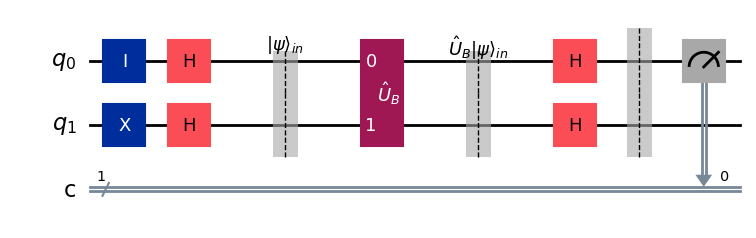

In [188]:
q = qk.QuantumRegister(2, name="q")
c = qk.ClassicalRegister(1, name="c")
deutsch = qk.QuantumCircuit(q, c, name="qc")

deutsch.id(q[0])
deutsch.x(q[1])

deutsch.h(q[0])
deutsch.h(q[1])

deutsch.barrier(label=r"$|\psi\rangle_{in}$")

blackbox = return_blackbox()

deutsch.append(blackbox, [0,1])

deutsch.barrier(label=r"$\hat{U}_B|\psi\rangle_{in}$")

deutsch.h(q[0])
deutsch.h(q[1])

deutsch.barrier()

## We only need to measure q0 to determine if f is balanced or constant
deutsch.measure(q[0], c)

deutsch.draw("mpl")

In [193]:
## We only need 1 shot
## We need to decompose the circuit in order for the simulator to read the blackbox instructions
counts = mSimulator.run(deutsch.decompose(), shots=1).result().get_counts(deutsch.decompose())

if ("0" in counts):
    print(r"0 state measured: f is a constant function")
elif ("1" in counts):
    print(r"1 state measured: f is a balanced function")

1 state measured: f is a balanced function


# Deutsch-Josza Algorithm

Input of a string of $n$ bits, thus $2^n$ different inputs, that has either balanced or constant outputs.

Classically, the function would have to be called exactly $2^{n-1}+1$ times to check if it is balanced or constant.